In [1]:
import matplotlib.pyplot as plt
import numpy as np

from keras import backend as K

from keras.datasets import mnist
from keras.layers import (
        Activation, BatchNormalization, Concatenate, Dense,
        Embedding, Flatten, Input, Multiply, Reshape)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model, Sequential
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
z_dim = 100
num_classes = 10

In [3]:
def build_generator(z_dim):
    generator_input = Input(shape=(z_dim,), name = 'generator_input')
    x = generator_input
    x = Dense(256*7*7)(x)
    x = Reshape((7, 7, 256))(x)
    x = Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Conv2DTranspose(64, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Conv2DTranspose(1, kernel_size=3, strides=2, padding='same')(x)
    x = Activation('tanh', name='generator_output')(x)
    generator_output = x
    generator = Model(generator_input, generator_output, name = 'generator')
    return generator

In [4]:
def build_cgan_generator(z_dim):
    z = Input(shape=(z_dim,), name = 'cgan_generator_input' )
    label_input = Input(shape=(1,), dtype='int32', name = 'label_input')
    label = Embedding(num_classes, z_dim, input_length=1)(label_input)
    label = Flatten()(label)
    label = Multiply()([z, label])
    generator = build_generator(z_dim)
    conditioned_img = generator(label)
    generator_model = Model([z, label_input], conditioned_img, name = 'cgan_generator')
    return generator_model

In [5]:
cgan_generator = build_cgan_generator(z_dim)

In [6]:
cgan_generator.summary()

Model: "cgan_generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
label_input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       1000        label_input[0][0]                
__________________________________________________________________________________________________
cgan_generator_input (InputLaye (None, 100)          0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 100)          0           embedding_1[0][0]                
_____________________________________________________________________________________

In [7]:
def build_discriminator(img_shape):
    discriminator_input = Input(shape=(img_shape[0], img_shape[1], img_shape[2] + 1), name='discriminator_input')
    x = discriminator_input
    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Flatten()(x)
    x = Dense(1, activation='sigmoid', name='discriminator_output')(x)
    discriminator_output = x
    discriminator = Model(discriminator_input, discriminator_output, name='discriminator')
    return discriminator

In [8]:
def build_cgan_discriminator(img_shape):
    cgan_discriminator_input = Input(shape=img_shape, name = 'cgan_discriminator_input')
    label_input = Input(shape=(1,), dtype='int32', name = 'label_input')
    label = Embedding(num_classes, np.prod(img_shape), input_length=1)(label_input)
    label = Flatten()(label)
    label = Reshape(img_shape)(label)
    x = Concatenate(axis=-1)([cgan_discriminator_input, label])
    discriminator = build_discriminator(img_shape)
    classification = discriminator(x)
    discriminator_model = Model([cgan_discriminator_input, label_input], classification, name = 'cgan_discriminator')
    return discriminator_model

In [9]:
cgan_discriminator = build_cgan_discriminator(img_shape)

In [10]:
cgan_discriminator.summary()

Model: "cgan_discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
label_input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 784)       7840        label_input[0][0]                
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 784)          0           embedding_2[0][0]                
__________________________________________________________________________________________________
cgan_discriminator_input (Input (None, 28, 28, 1)    0                                            
_________________________________________________________________________________

In [11]:
cgan_discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

cgan_discriminator.trainable = False

model_input = Input(shape=(z_dim,), name='model_input')
label = Input(shape=(1,), name='label_input')
img = cgan_generator([model_input, label])
model_output = cgan_discriminator([img, label])
GAN = Model([model_input, label], model_output)

GAN.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

cgan_discriminator.trainable = True

In [12]:
accuracies = []
losses = []
def train_discriminator(batch_size, imgs, labels):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    #реальные изображения
    d_loss_real = cgan_discriminator.train_on_batch([imgs, labels], real)
    
    #сгенерированные изображение
    z = np.random.normal(0,1,(batch_size, z_dim))
    gen_imgs = cgan_generator.predict([z, labels])
    d_loss_fake = cgan_discriminator.train_on_batch([gen_imgs, labels], fake)
    
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    return d_loss
    
def train_generator(batch_size):
    real = np.ones((batch_size, 1))
    z = np.random.normal(0, 1, (batch_size, z_dim))
    labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
    g_loss = GAN.train_on_batch([z, labels], real)
    
    return g_loss
    
def train(iterations, batch_size, sample_interval):
    (X_train, y_train), (_, _) = mnist.load_data()
    X_train = X_train / 127.5 - 1
    X_train = np.expand_dims(X_train, axis=3)

    for iteration in range(iterations):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], y_train[idx]
        
        #обучение
        d_loss = train_discriminator(batch_size, imgs, labels)
        g_loss = train_generator(batch_size)
        
        #сохранение и вывод результатов через интервал
        if (iteration + 1) % sample_interval == 0:
            print('{0} [D loss: {1}, acc.: {2}] [G loss: {3}]'.format(iteration + 1, d_loss[0], d_loss[1], g_loss))
            losses.append((d_loss[0], g_loss))
            accuracies.append(100 * d_loss[1])
            sample_images()

In [13]:
def sample_images(image_grid_rows = 2, image_grid_columns = 5):
    z = np.random.normal(0, 1,(image_grid_rows * image_grid_columns, z_dim))
    labels = np.arange(0, 10)
    gen_imgs = cgan_generator.predict([z, labels])
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axes = plt.subplots(image_grid_rows, image_grid_columns, figsize=(10, 4), sharey= True, sharex = True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axes[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axes[i, j].axis('off')
            axes[i, j].set_title('Digit: %d' % labels[cnt])
            cnt += 1

C:\Users\Yana\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\Yana\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarn

1000 [D loss: 0.03571445867419243, acc.: 1.0] [G loss: [4.93703, 0.0]]
2000 [D loss: 0.00029532972257584333, acc.: 1.0] [G loss: [9.289183, 0.0]]
3000 [D loss: 0.43770939111709595, acc.: 0.84375] [G loss: [1.0084685, 0.5625]]
4000 [D loss: 0.04206003621220589, acc.: 0.984375] [G loss: [1.6034406, 0.21875]]
5000 [D loss: 0.06704676896333694, acc.: 0.984375] [G loss: [3.9147234, 0.03125]]
6000 [D loss: 0.0005475840298458934, acc.: 1.0] [G loss: [5.1459827, 0.0]]
7000 [D loss: 1.0114918947219849, acc.: 0.609375] [G loss: [0.481274, 0.71875]]
8000 [D loss: 0.03401954844594002, acc.: 1.0] [G loss: [0.050157063, 0.96875]]


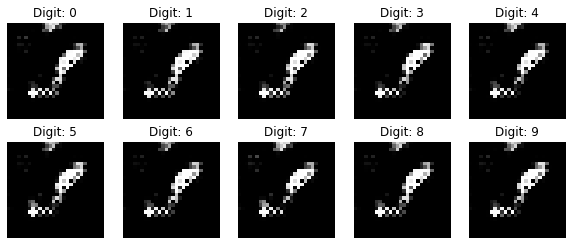

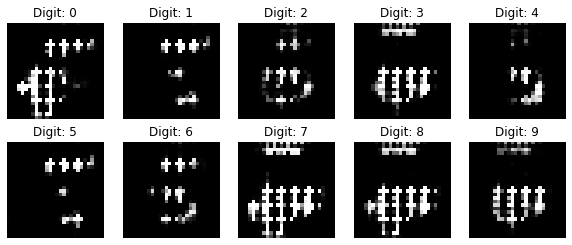

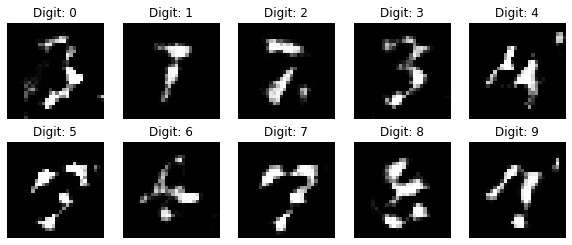

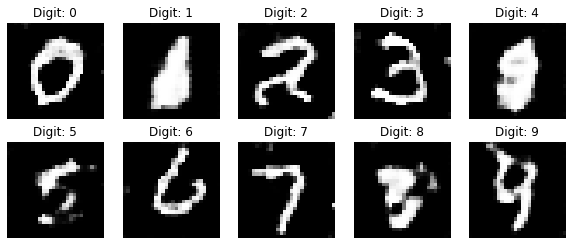

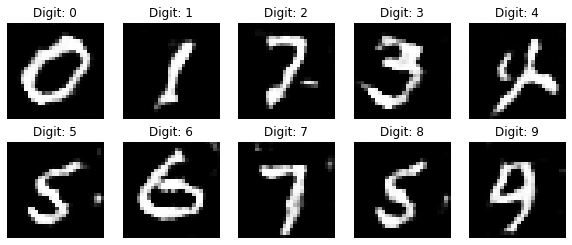

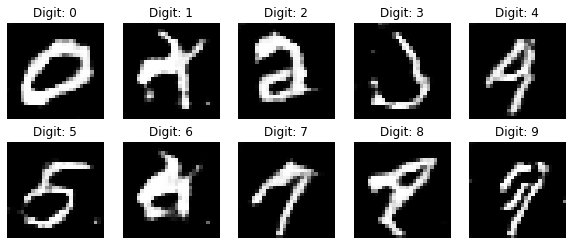

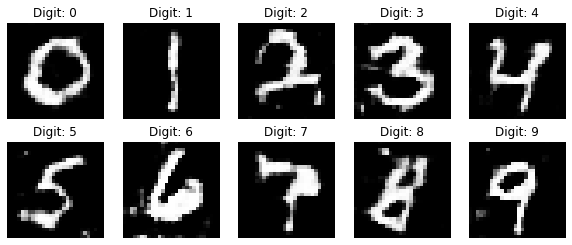

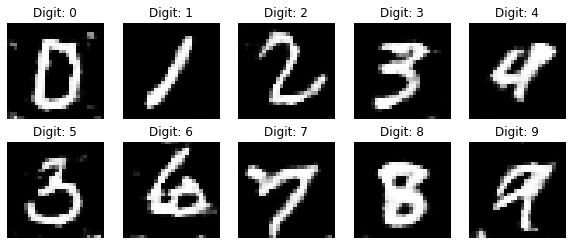

In [14]:
iterations = 8000
batch_size = 32
sample_interval = 1000
train(iterations, batch_size, sample_interval)

In [15]:
GAN.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
model_input (InputLayer)        (None, 100)          0                                            
__________________________________________________________________________________________________
label_input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
cgan_generator (Model)          (None, 28, 28, 1)    1638121     model_input[0][0]                
                                                                 label_input[0][0]                
__________________________________________________________________________________________________
cgan_discriminator (Model)      (None, 1)            122657      cgan_generator[1][0]       